In [56]:
import pandas as pd
import requests
import json
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [135]:
# Извлекаем данные из Я.Метрики
base_url = 'https://api-metrika.yandex.net/stat/v1/data?'
params = {'metrics': 'ym:s:visits',
'dimensions': ['ym:s:date','ym:s:browser', 'ym:s:isRobot'],
'id': '44147844'}
url = base_url + urlencode(params, doseq=True)
query = requests.get(url)
json_data = json.loads(query.text)
visits_data = pd.DataFrame([(
i['dimensions'][0]['name'],i['dimensions'][1]['name'],i['dimensions'][2]['name'],
i['metrics'][0]) for i in json_data['data']],
columns=['date','browser','user_type','visits'])

In [136]:
visits_data=visits_data.sort_values('date')

In [137]:
visits_data

,date,browser,user_type,visits
60,2021-05-29,Firefox,Robots,8.0
48,2021-05-29,Safari,People,10.0
19,2021-05-29,Chrome Mobile,People,38.0
53,2021-05-29,Edge,Robots,9.0
22,2021-05-29,Google Chrome,Robots,33.0
...,...,...,...,...
72,2021-06-04,Edge,Robots,6.0
11,2021-06-04,Google Chrome,Robots,71.0
7,2021-06-04,Google Chrome,People,93.0
98,2021-06-04,Opera,Robots,3.0


**Строим график посещений сайта роботами и людьми**

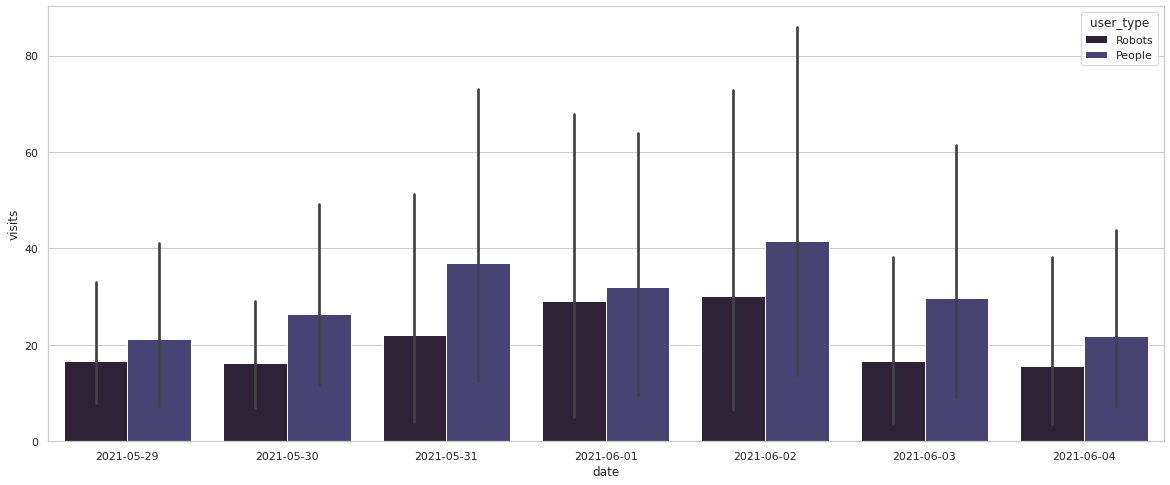

In [138]:
sns.set(style='whitegrid',palette='mako',rc={'figure.figsize':(20,8)})
sns.barplot(x='date',y='visits',data=visits_data,hue='user_type',order=visits_data.date.unique())

#можно отметить, что большего всего роботы посетили сайт 2021/06/02 , а люди 2021/05/31

**Определим долю посещений сайта по браузерам**

In [142]:
browser_data_grouped=visits_data.groupby('browser',as_index=False) \
            .agg({'visits':'sum'})

In [140]:
browser_data_grouped['CR']=browser_data_grouped.visits \
            .div(browser_data.visits.sum()).mul(100).round(2)

In [141]:
#По полученным данным видим, что наибольшая доля приходится на Google Chrome
browser_data_grouped.sort_values('CR',ascending=False)

,browser,visits,CR
4,Google Chrome,1540.0,55.36
10,Yandex Browser,277.0,9.96
1,Chrome Mobile,269.0,9.67
3,Firefox,189.0,6.79
8,Safari,112.0,4.03
2,Edge,105.0,3.77
6,Mobile Safari,101.0,3.63
7,Opera,49.0,1.76
9,Samsung Internet,30.0,1.08
0,Android Browser,28.0,1.01


**Выясним, с какого браузера приходит больше всего ботов.**

In [169]:
bot_vs_people_data=visits_data.groupby(['browser','user_type'],as_index=False) \
            .agg({'visits':'sum'})

In [188]:
bot_vs_people_data

,browser,user_type,visits
0,Android Browser,People,28.0
1,Chrome Mobile,People,269.0
2,Edge,People,56.0
3,Edge,Robots,49.0
4,Firefox,People,86.0
5,Firefox,Robots,103.0
6,Google Chrome,People,1051.0
7,Google Chrome,Robots,489.0
8,MSIE,Robots,3.0
9,Mobile Safari,People,101.0


In [184]:
bot_data=bot_vs_people_data.query('user_type=="Robots"').merge(browser_data_grouped, on='browser')

In [185]:
bot_data['bot_CR']=(100*bot_data.visits_x / bot_data.visits_y).round(2)

In [186]:
#Из полученных результатов видно, что это браузер MSIE
bot_data.sort_values('bot_CR',ascending=False)

,browser,user_type,visits_x,visits_y,bot_CR
3,MSIE,Robots,3.0,3.0,100.00
1,Firefox,Robots,103.0,189.0,54.50
0,Edge,Robots,49.0,105.0,46.67
4,Opera,Robots,16.0,49.0,32.65
2,Google Chrome,Robots,489.0,1540.0,31.75
5,Safari,Robots,16.0,112.0,14.29
6,Samsung Internet,Robots,4.0,30.0,13.33
7,Yandex Browser,Robots,7.0,277.0,2.53


**Построим график всех заходов на сайт от ботов и людей в разрезе по браузерам**

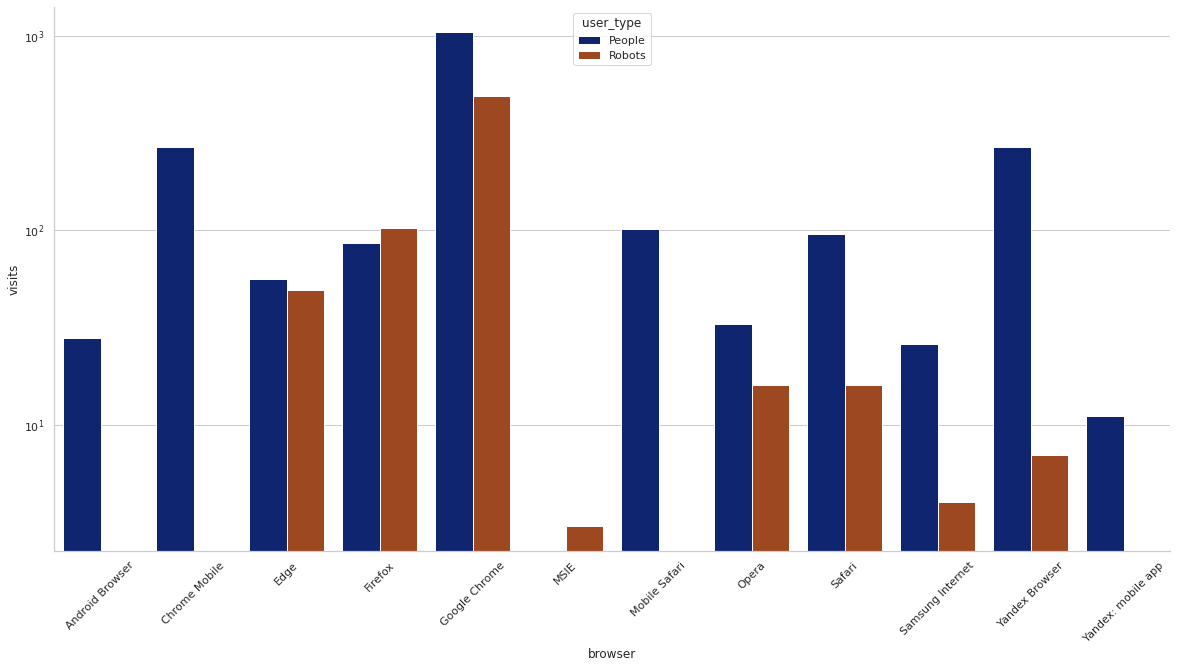

In [204]:
sns.set(style='whitegrid',palette='dark',rc={'figure.figsize':(20,10)})
sns.barplot(x='browser',y='visits',data=bot_vs_people_data,hue='user_type')
plt.yscale('log')
plt.xticks(rotation=45)
sns.despine()